In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [164]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics
from dataloader.animal_faces import AnimalfaceDataset

%reload_ext autoreload
%autoreload 2

In [51]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [52]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [119]:
width = 128
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
# train_transform = transforms.Compose([transforms.ToTensor()])

In [121]:
train_data = AnimalfaceDataset(transform=train_transform, img_width=width)

  0%|                                                                                      | 0/14630 [00:00<?, ?it/s]/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████| 14630/14630 [02:53<00:00, 84.47it/s]


In [122]:
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
val_data = AnimalfaceDataset(transform=val_transform, type="val", img_width=width)

100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 140.05it/s]


torch.Size([512, 3, 128, 128]) torch.Size([512])


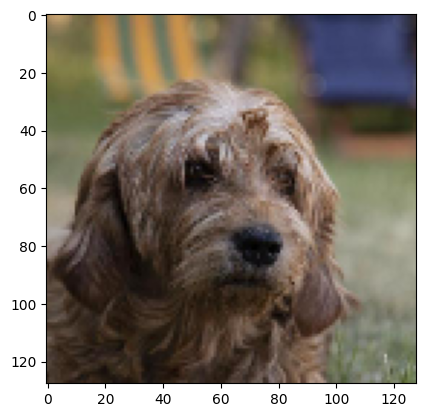

In [124]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(val_loader))
print(x.shape, y.shape)
show_img(x)

In [234]:
from models.auto_encoder import AutoEncoder, Encoder, Decoder
%reload_ext autoreload
%autoreload 2

In [235]:
# conv_ip_size = (128, 6, 6)
# feature_size = 2048 
# filters = [3,12,24,48,128]
# kernel_sizes = [7, 5, 3, 3]
# strides = [2, 2, 2, 2]
# output_paddings = [1,0,0,1]
# paddings = [0,0,0,0]


# feature_size = 128 
# filters = [3, 16, 32]
# kernel_sizes = [7,5]
# strides = [2,2]
# output_paddings = [0,1]
# paddings = [0,0]
# return_only_liner = 0
# dropout_prob = 0.05

# feature_size = 20 
# filters = [3, 32, 32, 64, 64, 256]
# kernel_sizes = [4, 4, 4, 4, 4]
# strides = [2,2,2,2,1]
# paddings = [1,1,1,1,0]
# output_paddings = [0,0,0,0,0]
# # paddings = [0,0]
# return_only_liner = 0
# dropout_prob = 0.05

feature_size = 32
filters = [3, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4]
strides = [2,2,2,2]
paddings = [0,0,0,0]
output_paddings = [0,1,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.0

if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 4096, feature_size]
else:
    conv_ip_size = (256,6,6)
#     hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 256*3, 256, feature_size]
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2]]    

In [236]:
e = Encoder(filters=filters, 
            kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hidden_sizes, 
            return_only_liner=return_only_liner, return_only_conv=1, paddings=paddings)
op = e(x)
print(op.shape)
# summary(e, (3,64,64), device="cpu")
summary(e, (3,width,width), device="cpu")

torch.Size([512, 9216])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]           1,568
              ReLU-2           [-1, 32, 63, 63]               0
            Conv2d-3           [-1, 64, 30, 30]          32,832
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 14, 14]         131,200
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 6, 6]         524,544
              ReLU-8            [-1, 256, 6, 6]               0
Total params: 690,144
Trainable params: 690,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 3.34
Params size (MB): 2.63
Estimated Total Size (MB): 6.16
----------------------------------------------------------------


In [237]:
op.flatten(start_dim=1).shape

torch.Size([512, 9216])

In [238]:
# d = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
#                                kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
#                                  paddings=paddings[::-1], hiddens_sizes=hidden_sizes[::-1] , return_only_conv=True)
# do = d(op.flatten(start_dim=1))
# print("hello-",do.shape)
# # summary(d, (feature_size,), device="cpu")
# summary(d, op.flatten(start_dim=1).shape, device="cpu")

In [239]:
ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

# summary(ae, (3,32,32), device="cuda")
summary(ae, (3,width,width), device="cuda")

[9216]
torch.Size([512, 3, 128, 128]) torch.Size([512, 9216])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]           1,568
              ReLU-2           [-1, 32, 63, 63]               0
            Conv2d-3           [-1, 64, 30, 30]          32,832
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 14, 14]         131,200
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 6, 6]         524,544
              ReLU-8            [-1, 256, 6, 6]               0
           Encoder-9                 [-1, 9216]               0
        Unflatten-10            [-1, 256, 6, 6]               0
  ConvTranspose2d-11          [-1, 128, 14, 14]         524,416
             ReLU-12          [-1, 128, 14, 14]               0
  ConvTranspose2d-13           [-1, 64, 3

In [240]:
show_img = lambda x: plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

In [ ]:
%%time
n_epochs = 100
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=1e-4)
losses = []
val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Epoch: {epoch} Loss {loss}")
        if i%1 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {val_loss}")
            if i%1 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

Epoch: 12 Loss 0.04934045672416687:  10%|████▋                                        | 3/29 [00:00<00:04,  5.51it/s]

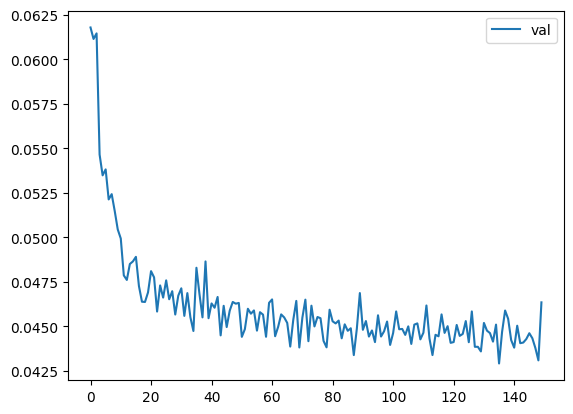

In [210]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[0:], label="val")
plt.legend()

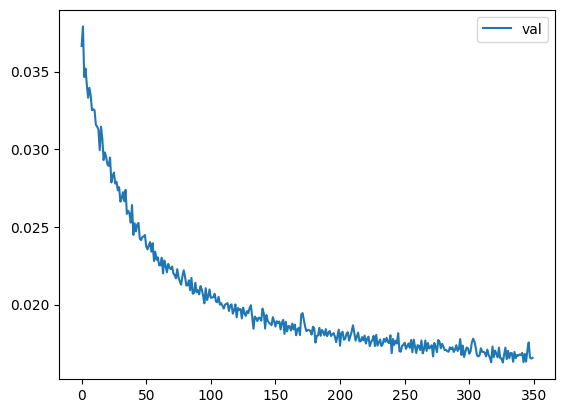

In [45]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[10:], label="val")
plt.legend()

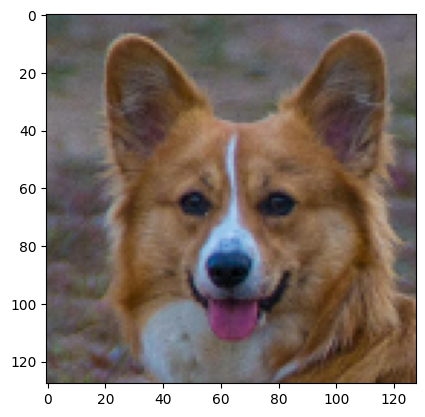

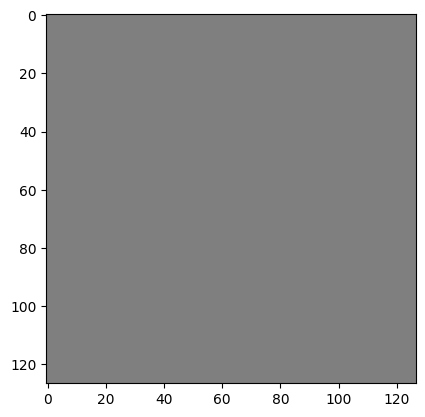

In [219]:
x, y = next(iter(val_loader))
with torch.no_grad():
    ae.eval()
    x_hat, enc = ae(x.to(device))
plt.figure()
show_img(x)
plt.figure()
show_img(x_hat)

### Observations
Effect of kernels size: 
Keep all constant (3)

effect of latent dim:
Try: 2048, 128X6X6

effect of number of filters: Looks like val loss decreasing if we increase number of filters

In [119]:
feature_size

2048

In [110]:
torch.save(ae.state_dict(), f"ckpts/autoencoder_{feature_size}_3l_gauss.pt")